# 개요
<br>
<br>

### A) EDA
- train/test Target의 이질성
- 문제 변환

### B) Feture Engineering
- hist_d에 대한 고찰
- 기존 데이터들 가공 
- 추가 데이터 및 외부 데이터
- Target Scaling

### C) Modeling
- CatBoost
- XGBoost

### D) Post Processing

### E) Ensemble

### F) Submission
  
    
    
---

# A) EDA

eda를 위한 파일 불러오기.

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path('../NH/data/')

stk_hld_train = data_dir / 'stk_hld_train.csv'
stk_hld_test = data_dir / 'stk_hld_test.csv'
stk_bnc_hist = data_dir / 'stk_bnc_hist.csv'
iem_info = data_dir / 'iem_info_20210902.csv'
cus_info = data_dir / 'cus_info.csv'
# vix_index = data_dir / 'CBOE_Volatility_Index.csv'      외부 데이터
# vix_index2 = data_dir / 'CBOE_Volatility_Index2.csv'    외부 데이터

sample_submission = data_dir / 'sample_submission.csv'

trn = pd.read_csv(stk_hld_train)
tst = pd.read_csv(stk_hld_test)
hist = pd.read_csv(stk_bnc_hist)
iem = pd.read_csv(iem_info)
cus = pd.read_csv(cus_info)
# vix = pd.read_csv(vix_index)       외부 데이터
# vix2 = pd.read_csv(vix_index2)     외부 데이터

sub = pd.read_csv(sample_submission)


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
trn = pd.merge(trn, cus, how = "left", on = ["act_id"])
trn = pd.merge(trn, iem, how = "left", on = ["iem_cd"])
trn = pd.merge(trn, hist, how = "left", on = ["act_id", "iem_cd"])
trn = trn[(trn["byn_dt"] == trn["bse_dt"])]
trn.reset_index(drop = True, inplace = True)


tst = pd.merge(tst, cus, how = "left", on = ["act_id"])
tst = pd.merge(tst, iem, how = "left", on = ["iem_cd"])
tst = pd.merge(tst, hist, how = "left", on = ["act_id", "iem_cd"])
tst = tst[(tst["byn_dt"] == tst["bse_dt"])]
tst.reset_index(drop = True, inplace = True)

우선 Train 데이터의 hold_d(target) 분포 정도를 간략하게 살펴보면 다음과 같다.

<AxesSubplot:>

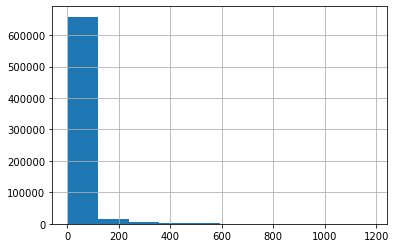

In [3]:
trn.hold_d.hist()

극심한 왜도로 인해 분포 정도를 정확하게 파악하기 힘들다.  
  따라서 좀 더 자세하게 살펴보면 다음과 같다.

In [4]:
trn.hold_d.describe()

count    681472.000000
mean         19.592600
std          52.651629
min           1.000000
25%           1.000000
50%           4.000000
75%          14.000000
max        1184.000000
Name: hold_d, dtype: float64

In [5]:
print(trn['hold_d'].median())

# 당일 거래
print(trn[trn['hold_d'] == 1].shape[0] / trn.shape[0] * 100)

# 일주일 이상 보유 한 거래
print(trn[trn['hold_d'] > 7].shape[0] / trn.shape[0] * 100)

# 한달 이상 보유 한 거래는 13프로에 그친다.
print(trn[trn['hold_d'] > 31].shape[0] / trn.shape[0] * 100)

4.0
27.881996619083395
35.94747839969947
13.786920078888054


- "절반" 이상의 거래는 4일 이내에 매도가 이루어졌다.<br>
- train 전체 데이터(68만 이상의 거래) 중 "4분의 1" 이상의 거래가 당일에 매수, 매도가 이루어졌다.<br>
- 일주일 이상 보유 한 거래는  "35프로"이며,<br>
- 한달 이상 보유 한 거래는  "13프로"에 그친다.

### - train/test Target의 이질성   
<br>
앞서 말했듯이 Train 데이터 중 한달 이상 보유 한 거래는 13프로에 그친다.  <br>    
하지만 Test 데이터 중에 2020년 12월에 매수 된 거래들을 제외한 모든 데이터들은 보유기간이 "최소 한달 이상"이다.<br>
따라서 Test 데이터셋을 인위로 나눠주고, 나눠진 각 Test 데이터셋들에 걸맞게 Train 데이터셋을 매칭 시켜준다.<br>
<br>
Test 데이터셋을 나눠주기 전에 매수 시점에 따른 데이터 분포정도를 확인하면 다음과 같다.

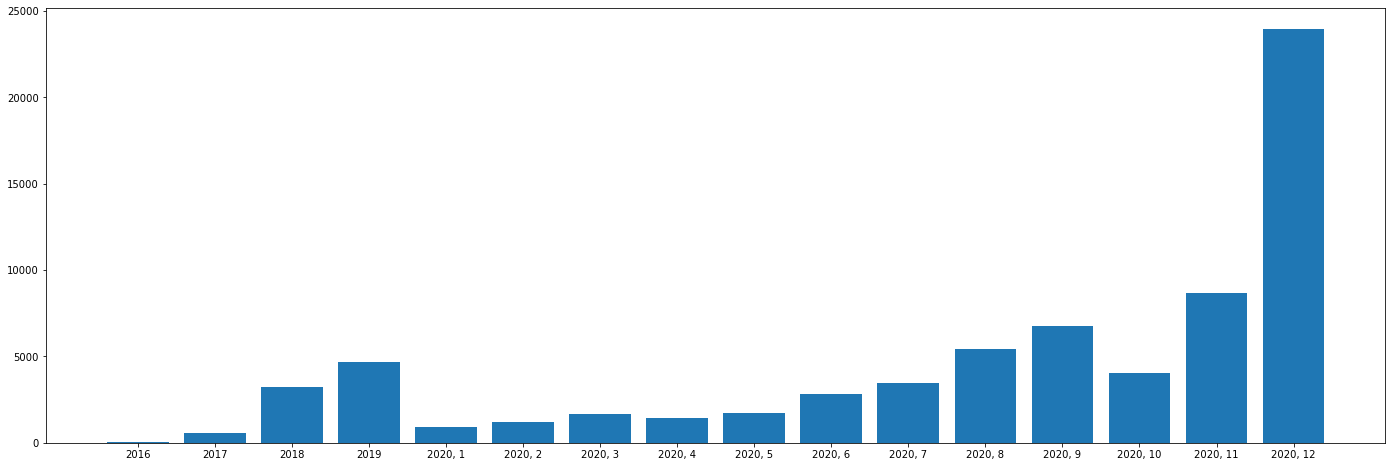

In [6]:
buy_date = []

# 2020년도의 데이터가 다른연도에 비해 월등히 많으므로 2020년만 1월부터 12월까지 데이터를 나눠줌.
buy_date.append(tst[tst['byn_dt'] < 20170000].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20170000) & (tst['byn_dt'] < 20180000)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20180000) & (tst['byn_dt'] < 20190000)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20190000) & (tst['byn_dt'] < 20200000)].shape[0])

buy_date.append(tst[(tst['byn_dt'] > 20200100) & (tst['byn_dt'] < 20200200)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200200) & (tst['byn_dt'] < 20200300)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200300) & (tst['byn_dt'] < 20200400)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200400) & (tst['byn_dt'] < 20200500)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200500) & (tst['byn_dt'] < 20200600)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200600) & (tst['byn_dt'] < 20200700)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200700) & (tst['byn_dt'] < 20200800)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200800) & (tst['byn_dt'] < 20200900)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20200900) & (tst['byn_dt'] < 20201000)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20201000) & (tst['byn_dt'] < 20201100)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20201100) & (tst['byn_dt'] < 20201200)].shape[0])
buy_date.append(tst[(tst['byn_dt'] > 20201200) & (tst['byn_dt'] < 20210000)].shape[0])


date_index = ["2016","2017","2018","2019"]
for i in range(1,13):
    date_index.append(f'2020, {i}')
    
    
# Plot 
plt.figure(figsize=(24,8))
plt.bar(date_index,buy_date)
plt.show()

### - 문제 변환
<br><br>
총 세 가지 데이터셋으로 split 해주었다. (train1/test1, train2/test2, train3/test3)<br><br>
매도 기간 : 2021.01.01 ~ 2021.07.31<br><br>
<b>Test1</b><br>
매수 기준 2020년 12월 1일 ~ 2020년 12월 31일 사이의 데이터 사용<br>
$hist_d < 22$ <br><br>
<b>Train1</b><br>
train의 hold_d가 2이상 168 미만인 데이터 사용<br>
$1 < 매도기간 < 146$<br>
$+$<br>
$1 < hist_d < 22$<br><br>

<b>Test2</b><br>
매수 기준 2020년 8월 11일 ~ 2020년 11월 30일 사이의 데이터 사용<br>
$21 < hist_d < 97$ <br><br>
<b>Train2</b><br>
train의 hold_d가 22초과 242 미만인 데이터 사용<br>
$1 < 매도기간 < 146$<br>
$+$<br>
$21 < hist_d < 97$<br><br>

<b>Test3</b><br>
매수 기준 2016년 1월 4일 ~ 2020년 8월 10일 사이의 데이터 사용<br>
$hist_d > 96$ <br><br>
<b>Train3</b><br>
train의 hold_d가 97초과인 데이터 사용<br>
$hold_d > 97$<br>

In [7]:
# 2020년 12월 1일 ~ 2020년 12월 31일 사이에 매수
tst_1 = tst[tst['hist_d'] < 22]
trn_1 = trn[(trn['hold_d'] > 1) & (trn['hold_d'] < 168)]

# 2020년 8월 11일 ~ 2020년 11월 30일 사이에 매수
tst_2 = tst[(tst['hist_d'] > 21) & (tst['hist_d'] < 97)]
trn_2 = trn[(trn['hold_d'] > 22) & (trn['hold_d'] < 242)]

# 2016년 1월 4일 ~ 2020년 8월 10일 사이에 매수
tst_3 = tst[tst['hist_d'] > 96]
trn_3 = trn[trn['hold_d'] >97]

# B) Feature Engineering

### - hist_d에 대한 고찰


사실 전처리 과정에서 제일 감이 안잡히고 어려웠던 부분이 hist_d 데이터이다.<br>
hist_d 데이터 생성의 원천은 Test 데이터의 매수 시점으로 부터 2021년 1월 1일 이전까지의 보유기간이다.<br>
이를 Train 데이터에 추가적으로 만들어 주려면 매수 시점을 기점으로 특정 시점까지의 보유기간을 인위적으로 만들어 주어야 한다.<br>
하지만 이때 특정 시점을 정할 방법이 없을 뿐더러 만약 비논리적으로 train 데이터의 target(hold_d)에 광역으로 산수를 해주면 모델링을 해줄때 학습 과정에서 hist_d 데이터에 편향되어 질 것이라 생각했다. 실제로 초반부에 모델링 과정에서 피처 중요도(Feature Importance)를 출력해 보았을때, 97,98% 부분이 hist_d 데이터에 해당되었다.<br>
따라서 hist_d 데이터는 모델링 과정에서 사용하지 않았다.

### - 기존 데이터들 가공

기존 데이터들(성별,연령대,투자성향,자산구간 등등)은 이미 "카테고리화"가 된 데이터들이다.<br>
이 데이터들의 대부분을 그대로 OneHotEncoding을 적용시켜 데이터셋을 만들기에는 column의 수가 방대해질 것이다.<br>
학습에 효율성이 떨어질 것으로 판단하여 hold_d의 평균값과 중앙값을 기준으로 비슷한 양상을 보이는 카테고리들 끼리 Grouping 해주었다.<br>또한 mrz_btp_dit_cd 같이 카테고리의 수가 16개로서 주관적으로 grouping 하기 어려운 경우에는 KMeans 알고리즘을 이용하여 clustering해주었다.<br>
데이터 전처리는 분할된 3개의 데이터셋 개별적으로 진행하였다.

In [8]:
# 각 Feature들의 카테고리별 hold_d의 평균값, 중앙값 출력.
part_columns = ['sex_dit_cd',
'cus_age_stn_cd',
 'ivs_icn_cd',
 'cus_aet_stn_cd',
 'mrz_pdt_tp_sgm_cd',
 'lsg_sgm_cd',
 'tco_cus_grd_cd',
 'tot_ivs_te_sgm_cd',
 'mrz_btp_dit_cd',
 'btp_cfc_cd',
 'mkt_pr_tal_scl_tp_cd',
 'stk_dit_cd']

print('###################################Dataset 1###################################')
for i in part_columns:
    temp1 = trn_1.groupby(i)['hold_d'].size()
    temp2 = tst_1.groupby(i)['hold_d'].size()
    temp3 = trn_1.groupby(i)['hold_d'].mean()
    temp4 = trn_1.groupby(i)['hold_d'].median()
    print('####################################################')
    print('####################################################')
    print('Train :[Feature별 사이즈] Feature :',temp1,'\n')
    print('Test  :[Feature별 사이즈] Feature :',temp2,'\n')
    print('Train :[Feature별 평균값] Feature :',temp3,'\n')
    print('Train :[Feature별 중앙값] Feature :',temp4)
    
print('###################################Dataset 2###################################')
for i in part_columns:
    temp1 = trn_2.groupby(i)['hold_d'].size()
    temp2 = tst_2.groupby(i)['hold_d'].size()
    temp3 = trn_2.groupby(i)['hold_d'].mean()
    temp4 = trn_2.groupby(i)['hold_d'].median()
    print('####################################################')
    print('####################################################')
    print('Train :[Feature별 사이즈] Feature :',temp1,'\n')
    print('Test  :[Feature별 사이즈] Feature :',temp2,'\n')
    print('Train :[Feature별 평균값] Feature :',temp3,'\n')
    print('Train :[Feature별 중앙값] Feature :',temp4)

print('###################################Dataset 3###################################')
for i in part_columns:
    temp1 = trn_3.groupby(i)['hold_d'].size()
    temp2 = tst_3.groupby(i)['hold_d'].size()
    temp3 = trn_3.groupby(i)['hold_d'].mean()
    temp4 = trn_3.groupby(i)['hold_d'].median()
    print('####################################################')
    print('####################################################')
    print('Train :[Feature별 사이즈] Feature :',temp1,'\n')
    print('Test  :[Feature별 사이즈] Feature :',temp2,'\n')
    print('Train :[Feature별 평균값] Feature :',temp3,'\n')
    print('Train :[Feature별 중앙값] Feature :',temp4)

###################################Dataset 1###################################
####################################################
####################################################
Train :[Feature별 사이즈] Feature : sex_dit_cd
1    308966
2    167837
Name: hold_d, dtype: int64 

Test  :[Feature별 사이즈] Feature : sex_dit_cd
1    13789
2    10197
Name: hold_d, dtype: int64 

Train :[Feature별 평균값] Feature : sex_dit_cd
1    17.590094
2    19.005404
Name: hold_d, dtype: float64 

Train :[Feature별 중앙값] Feature : sex_dit_cd
1    7
2    8
Name: hold_d, dtype: int64
####################################################
####################################################
Train :[Feature별 사이즈] Feature : cus_age_stn_cd
1    10098
2    42073
3    59126
4    78606
5    66740
6    78704
7    62534
8    48747
9    30175
Name: hold_d, dtype: int64 

Test  :[Feature별 사이즈] Feature : cus_age_stn_cd
1     874
2    2928
3    3148
4    3839
5    3135
6    3786
7    2958
8    2149
9    1169
Name: hold_d, dtyp

####################################################
####################################################
Train :[Feature별 사이즈] Feature : ivs_icn_cd
0      1840
1      1738
2     15778
3     22232
4     27703
5     17775
9        41
99    26091
Name: hold_d, dtype: int64 

Test  :[Feature별 사이즈] Feature : ivs_icn_cd
0      383
1      391
2     3600
3     4618
4     5089
5     2847
9        2
99    6262
Name: hold_d, dtype: int64 

Train :[Feature별 평균값] Feature : ivs_icn_cd
0     68.948913
1     64.121979
2     62.527443
3     61.626889
4     64.733711
5     67.457271
9     64.658537
99    65.643939
Name: hold_d, dtype: float64 

Train :[Feature별 중앙값] Feature : ivs_icn_cd
0     52
1     48
2     46
3     45
4     47
5     49
9     52
99    48
Name: hold_d, dtype: int64
####################################################
####################################################
Train :[Feature별 사이즈] Feature : cus_aet_stn_cd
1    22729
2    29527
3    14913
4    19507
5    20219
6     6303
Nam

Name: hold_d, dtype: int64
####################################################
####################################################
Train :[Feature별 사이즈] Feature : tot_ivs_te_sgm_cd
1      286
2     2204
3    16867
4     7226
5     1786
6      829
Name: hold_d, dtype: int64 

Test  :[Feature별 사이즈] Feature : tot_ivs_te_sgm_cd
1      566
2     5581
3    12070
4     3650
5      980
6      571
Name: hold_d, dtype: int64 

Train :[Feature별 평균값] Feature : tot_ivs_te_sgm_cd
1    197.045455
2    150.050817
3    212.506492
4    247.804318
5    220.742441
6    262.934861
Name: hold_d, dtype: float64 

Train :[Feature별 중앙값] Feature : tot_ivs_te_sgm_cd
1    144
2    125
3    169
4    194
5    162
6    187
Name: hold_d, dtype: int64
####################################################
####################################################
Train :[Feature별 사이즈] Feature : mrz_btp_dit_cd
1      261
2      995
3      115
4      132
5     2323
6      978
7      996
8     1700
9     3302
10    7882
11    

- 위의 데이터에 기초하여 각 데이터셋의 피처들을 다음과 같이 Grouping 하였다. <br><br>

Dataset_1<br><br>

sex_dit_cd           : 원본 사용<br>
cus_age_stn_cd       : [1,2,7,8] , [3,4,5,6] , [9]  -> Make 3 dummies(OneHot)<br>
ivs_icn_cd           : [5,9] , [그 외] -> Make 2 dummies(OneHot)<br>
cus_aet_stn_cd       : [1,2,3,4] , [그 외] -> Make 2 dummies(OneHot)<br>
mrz_pdt_tp_sgm_cd    : Drop <br>
lsg_sgm_cd           : [9] , [2,3,5,6,7,8] , [4] -> Make 3 dummies(OneHot)<br>
tco_cus_grd_cd       : [99] , [5] , [1,3,4,9] , [2] --> Make 4 dummies(OneHot)<br>
tot_ivs_te_sgm_cd    : [1,2,6] , [그 외] -> Make 2 dummies(OneHot)<br>
mrz_btp_dit_cd       : Kmeans 알고리즘을 이용한 군집화.<br>
btp_cfc_cd           : Kmeans 알고리즘을 이용한 군집화.<br>
mkt_pr_tal_scl_tp_cd : [2,3] , [그 외] -> Make 2 dummies(OneHot)<br>
stk_dit_cd           : [1] , [그 외] -> Make 2 dummies(OneHot)<br><br>

Dataset_2<br><br>

sex_dit_cd           : Drop<br>
cus_age_stn_cd       : [1,2] , [3,4] , [5,6] , [7,8] ,[그 외]-> Make 5 dummies(OneHot)<br>
ivs_icn_cd           : [0,5] , [그 외] -> Make 2 dummies(OneHot)<br>
cus_aet_stn_cd       : [1,3,4] , [그 외] -> Make 2 dummies(OneHot)<br>
mrz_pdt_tp_sgm_cd    : Drop <br>
lsg_sgm_cd           : [9] , [2,3,7,8] , [그 외] -> Make 3 dummies(OneHot)<br>
tco_cus_grd_cd       : [99] , [3,4,5,9] , [그 외] -> Make 3 dummies(OneHot)<br>
tot_ivs_te_sgm_cd    : [1,2] , [3,6] , [그 외] -> Make 3 dummies(OneHot)<br>
mrz_btp_dit_cd 　　  : Kmeans 알고리즘을 이용한 군집화.<br>
btp_cfc_cd           : Kmeans 알고리즘을 이용한 군집화.<br>
mkt_pr_tal_scl_tp_cd : [1,2] , [그 외] -> Make 2 dummies(OneHot)<br>
stk_dit_cd           : 바로 OneHot<br>

Dataset_3<br><br>

sex_dit_cd           : Drop<br>
cus_age_stn_cd       : [1,2] , [3,4] , [5,6] , [7,8] ,[그 외]-> Make 5 dummies(OneHot)<br>
ivs_icn_cd           : [1] , [2,3,4,9] , [0,5] , [그 외] -> Make 4 dummies(OneHot)<br>
cus_aet_stn_cd       : [5] , [그 외] -> Make 2 dummies(OneHot)<br>
mrz_pdt_tp_sgm_cd    :drop <br>
lsg_sgm_cd           : [2] , [3,6,8] , [4,5,9] , [7] -> Make 4 dummies(OneHot)<br>
tco_cus_grd_cd       : [2,4,5,9] , [그 외] -> Make 2 dummies(OneHot)<br>
tot_ivs_te_sgm_cd    : 바로 OneHot<br>
mrz_btp_dit_cd       : Kmeans 알고리즘을 이용한 군집화.<br>
btp_cfc_cd           : Kmeans 알고리즘을 이용한 군집화.<br>
mkt_pr_tal_scl_tp_cd : 바로 OneHot<br>
stk_dit_cd           : 바로 OneHot<br>

### - 추가 데이터 및 외부 데이터

- 추가 데이터

In [9]:
# """aet_qty"""   : 잔고금액 / 잔고 수량  
# """user_char""" : 각 유저별 과거 거래 특성 : 평균 보유 기간이 단기적인지 장기적인지
# """num_tra"""   : 각 유저별 총 거래 횟수 

In [10]:
### """aet_qty"""
### 잔고금액 / 잔고 수량
### 간단한 산수 진행 후 데이터의 왜도가 커서 log 함수 적용.

# trn_1["aet_qty"] = trn_1["tot_aet_amt"] / trn_1["bnc_qty"]
# tst_1["aet_qty"] = tst_1["tot_aet_amt"] / tst_1["bnc_qty"]
# trn_1["aet_qty"] = trn_1["aet_qty"].apply(np.log1p)
# tst_1["aet_qty"] = tst_1["aet_qty"].apply(np.log1p)

# trn_2["aet_qty"] = trn_2["tot_aet_amt"] / trn_2["bnc_qty"]
# tst_2["aet_qty"] = tst_2["tot_aet_amt"] / tst_2["bnc_qty"]
# trn_2["aet_qty"] = trn_2["aet_qty"].apply(np.log1p)
# tst_2["aet_qty"] = tst_2["aet_qty"].apply(np.log1p)

# trn_3["aet_qty"] = trn_3["tot_aet_amt"] / trn_3["bnc_qty"]
# tst_3["aet_qty"] = tst_3["tot_aet_amt"] / tst_3["bnc_qty"]
# trn_3["aet_qty"] = trn_3["aet_qty"].apply(np.log1p)
# tst_3["aet_qty"] = tst_3["aet_qty"].apply(np.log1p)

In [11]:
### """user_char""" 
### 유저별 거래 특성: 보유 기간이 단기적인지 장기적인지
### act_id 기준으로 grouping 하여 유저 특성 별로 clustering

# user_mean = trn_3.groupby(['act_id'])['hold_d'].mean().reset_index()
# user_median = trn_3.groupby(['act_id'])['hold_d'].median().reset_index()
# user_hold = pd.merge(user_mean, user_median, how='left', on=['act_id'])

# kmeans = KMeans(n_clusters=4, random_state = 2)
# km_cluster = kmeans.fit_predict(user_hold.iloc[:,1:3])

# user_hold['user_hold'] = km_cluster
# user_hold.drop(['hold_d_x','hold_d_y'], axis=1, inplace=True)

# trn_3 = pd.merge(trn_3, user_hold, how='left', on=['act_id'])
# tst_3 = pd.merge(tst_3, user_hold, how='left', on=['act_id'])

# trn_3 = pd.concat([trn_3,pd.get_dummies(trn_3['user_hold'], prefix='user_hold')], axis=1)
# tst_3 = pd.concat([tst_3,pd.get_dummies(tst_3['user_hold'], prefix='user_hold')], axis=1)

In [12]:
### """num_tra""" 
### 유저별로 거래한 횟수
### act_id 기준으로 grouping 한 뒤 각 유저별 거래한 횟수.

# user_size = trn_3.groupby(['act_id']).size().reset_index()
# user_size.rename(columns = {0 : 'user_size'},inplace=True)

# # 유저별 거래 횟수에 극단적인 값들이 포합되어 있어, MinMaxScale이 아닌 robust scaling을 해줌.
# scaler_X = np.array(user_size['user_size']).reshape(-1,1)
# feature_robustscaler = RobustScaler()
# feature_robustscaler.fit(scaler_X)
# X_scaled = feature_robustscaler.transform(scaler_X)
# user_size['user_size'] = X_scaled

# trn_3 = pd.merge(trn_3, user_size, how='left', on=['act_id'])
# tst_3 = pd.merge(tst_3, user_size, how='left', on=['act_id'])

- 외부 데이터

외부 데이터로는 코스피 지수와 코스피 200 지수를 사용하였다.<br>
코스피란 한국종합주가지수로 유가증권시장에 상장된 종목들의 주식 가격을 종합적으로 표시한 수치이다.(KOSPI: Korea Composite Stock Price Index)<br>
코스피 200 지수는 유가증권시장을 대표하는 200개의 종목만을 지수화 한것이다.<br>
코스피 지수와 흔히 공포 지수라고 불리는 코스피200 지수는 투자자들의 심리에 큰 영향을 미칠 것이라 판단하였고, 이는 보유 기간과도 연관이 있다 생각하여 외부 데이터로서 활용하였다.<br><br>
https://kr.investing.com/indices/kospi-200<br>
https://kr.investing.com/indices/kospi<br>
위의 링크(인베스팅닷컴)에서 데이터 추출 가능.

### - Target Scaling
<br>
다음과 같이 각 train data(trn_1, trn_2, trn_3)의 Target Value(hold_d)의 분포를 살펴보면 왜도가 극심한 것을 알 수 있다.<br>
따라서 각 Target Column에 log 함수를 적용 시켜주어 왜도를 줄여주었다.

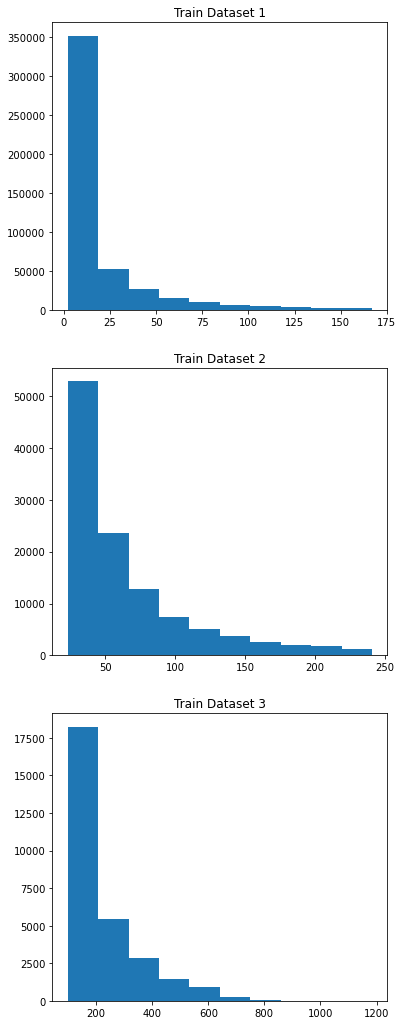

In [13]:
plt.figure(figsize=(6,18))

plt.subplot(3, 1, 1)                # trn_1
plt.hist(trn_1.hold_d)
plt.title('Train Dataset 1')

plt.subplot(3, 1, 2)                # trn_2
plt.hist(trn_2.hold_d)
plt.title('Train Dataset 2')

plt.subplot(3, 1, 3)                # trn_3
plt.hist(trn_3.hold_d)
plt.title('Train Dataset 3')

plt.show()

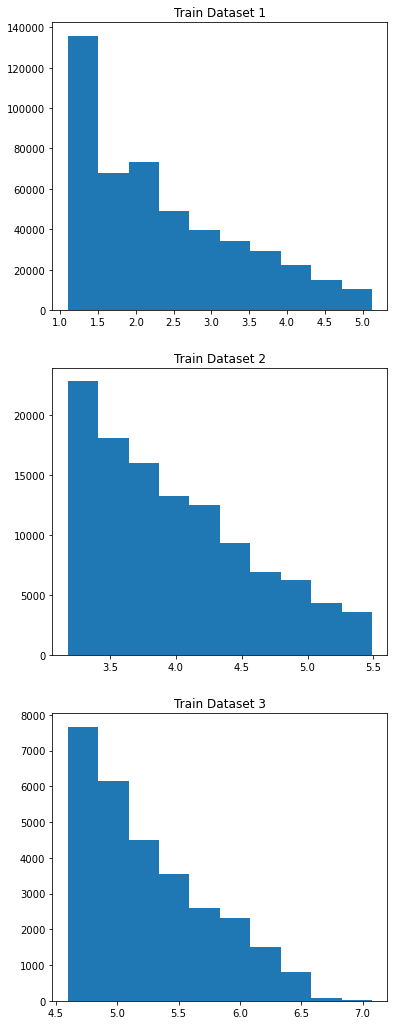

In [14]:
# 로그 함수를 취해준 뒤 결과값 확인.

trn_1['hold_d'] = trn_1['hold_d'].apply(np.log1p)
trn_2['hold_d'] = trn_2['hold_d'].apply(np.log1p)
trn_3['hold_d'] = trn_3['hold_d'].apply(np.log1p)

plt.figure(figsize=(6,18))

plt.subplot(3, 1, 1)                # trn_1
plt.hist(trn_1.hold_d)
plt.title('Train Dataset 1')

plt.subplot(3, 1, 2)                # trn_2
plt.hist(trn_2.hold_d)
plt.title('Train Dataset 2')

plt.subplot(3, 1, 3)                # trn_3
plt.hist(trn_3.hold_d)
plt.title('Train Dataset 3')

plt.show()

# C) Modeling
<br><br>
빠르고 강력한 CatBoost와 XGBoost를 활용하여 모델링을 진행하였다.<br>
Lightgbm도 고려하였지만 overfitting에 민감하고 특히 작은 데이터에 대해서 과적합되기 쉽다고 판단하여 사용하지 않았다.

- Catboost

In [15]:
def model_catboost(X_trn, y_trn, X_val, y_val, tst):
  model_catboost = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   depth=6,
                                   eval_metric='RMSE',
                                   random_seed = 42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20,
                                   task_type="GPU"
                                   )

  model_catboost.fit(X_trn, y_trn,
                    eval_set=(X_val, y_val),
                    use_best_model=True,
                    verbose=50
                    )
  predict = model_catboost.predict(tst)
  return predict

- xgboost

In [16]:
def model_xgboost(X_trn, y_trn, X_val, y_val, tst):
    params = {
          'objective': 'reg:squarederror', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42
          
    }

    training_data = xgb.DMatrix(X_trn, y_trn)
    validation_data = xgb.DMatrix(X_val, y_val)

    watchlist = [(training_data, 'train'), (validation_data, 'valid')]

    model_xgb = xgb.train(params, training_data, 2400, watchlist, maximize=False, early_stopping_rounds=100, verbose_eval=100 )

    data_test = xgb.DMatrix(tst)
    predict_test_xgb = model_xgb.predict(data_test, ntree_limit=model_xgb.best_ntree_limit )

    return predict_test_xgb

# D) Post Processing

앞서 Target에 대해서 log 함수를 취해주었었다. 이는 Target이 Scaling 된 것인데, 모델링 과정에서 나온 예측 값 또한 Scaling 되어진 값들 이다.<br>
따라서 각 데이터셋에 대해서 데이터에 특성에 맞게 특정 범위로 Mapping 시켜 주었다.<br><br>
데이터셋 1,2,3 순차적으로 hist_d 값은 커진다.<br>
이에 예측 값에 대한 오류를 최대한으로 줄여주기 위해 데이터셋이 커질수록 Mapping 범위를 최소한으로 줄여주었다. <br><br>
Dataset1 -> Mapping to 10 ~ 120<br>
Dataset2 -> Mapping to 50 ~ 120<br>
Dataset3 -> Mapping to 70 ~ 140

In [17]:
def post_processing(predict1, predict2, predict3, tst_1, tst_2, tst_3):
    # rescaling predict result

    s_1 = MinMaxScaler(feature_range=(10,120))
    s_2 = MinMaxScaler(feature_range=(50,120))
    s_3 = MinMaxScaler(feature_range=(70,140))

    scaled_predict1 = s_1.fit_transform(predict1)
    scaled_predict2 = s_2.fit_transform(predict2)
    scaled_predict3 = s_3.fit_transform(predict3)

    scaled_predict1 = np.ceil(scaled_predict1)
    scaled_predict2 = np.ceil(scaled_predict2)
    scaled_predict3 = np.ceil(scaled_predict3)
    
    sub_1 = tst_1[['submit_id']]
    sub_1['predict_1'] = scaled_predict1

    sub_2 = tst_2[['submit_id']]
    sub_2['predict_2'] = scaled_predict2

    sub_3 = tst_3[['submit_id']]
    sub_3['predict_3'] = scaled_predict3

    sub_ = pd.concat([sub_1,sub_2,sub_3])
    sub_ = sub_.sort_values(by=['submit_id'])
    sub_ = sub_.fillna(0)

    return (sub_['predict_1'] + sub_['predict_2'] + sub_['predict_3'])

# E) Ensemble

각 모델에서 학습된 예측 값들을 앙상블 해주었다.<br>
각 모델을 합친 평균값 사용.

In [18]:
# xgb_predict = post_processing(xgb_predict1, xgb_predict2, xgb_predict3, tst_1, tst_2, tst_3)
# cat_predict = post_processing(cat_predict1, cat_predict2, cat_predict3, tst_1, tst_2, tst_3)
# predict_hold_d = np.ceil(0.5*cat_predict + 0.5*xgb_predict)
# predict_hold_d.index = sub.index

# F) Submission

제출 파일 생성

In [19]:
# sub['hold_d'] = tst['hist_d'] + predict_hold_d

In [20]:
# sub.to_csv("ensemble_model_9.csv", index = False)